In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils

In [23]:
#open and combine all data
base_key = 'BTCUSD'
other_keys =('ETHUSD', 'SOLUSD', 'DOTUSD', 'ADAUSD', 'ALGOUSD')
full_df = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC_7-13-2023', base_key+'.csv'))
full_df['dtime'] = pd.to_datetime(full_df['dtime'], format='%Y-%m-%d %H:%M:%S')
full_df.set_index('dtime', inplace = True)
full_df.drop(columns=['time'], inplace=True)
full_df = full_df.add_prefix(base_key+'_')

for key in other_keys:
    price_data = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC_7-13-2023', key+'.csv'))
    price_data['dtime'] = pd.to_datetime(price_data['dtime'], format='%Y-%m-%d %H:%M:%S')
    price_data.set_index('dtime', inplace = True)
    price_data.drop(columns=['time'], inplace=True)
    price_data = price_data.add_prefix(key+'_')
    full_df = pd.merge_asof(full_df, price_data, left_index=True, right_index=True, direction='nearest')

full_df.dropna(inplace=True, axis=0, how='all')

#normalize data
norm_df = full_df.copy()
for key in full_df.keys():
    norm_df[key] = (full_df[key] - full_df[key].mean()) / full_df[key].std()

In [25]:
norm_df.values.shape    

(630528, 42)

In [26]:
norm_df

,BTCUSD_open,BTCUSD_high,BTCUSD_low,BTCUSD_close,BTCUSD_vwap,BTCUSD_volume,BTCUSD_count,ETHUSD_open,ETHUSD_high,ETHUSD_low,...,ADAUSD_vwap,ADAUSD_volume,ADAUSD_count,ALGOUSD_open,ALGOUSD_high,ALGOUSD_low,ALGOUSD_close,ALGOUSD_vwap,ALGOUSD_volume,ALGOUSD_count
dtime,,,,,,,,,,,,,,,,,,,,,
2022-04-13 17:33:00,2.927540,2.925667,2.929459,2.927579,2.777088,-0.199009,-0.329345,3.481796,3.480127,3.483342,...,3.003636,0.136680,0.043855,3.437836,3.436545,3.438885,3.437627,-0.608540,-0.089799,-0.290110
2022-04-13 17:34:00,2.927540,2.925667,2.919971,2.918094,2.773286,-0.182037,0.240725,3.481796,3.480151,3.478794,...,3.002958,-0.143306,-0.226992,3.420963,3.419676,3.422008,3.420755,3.950679,-0.089220,-0.052402
2022-04-13 17:35:00,2.918054,2.916462,2.918544,2.918355,2.767672,-0.190197,-0.129820,3.475357,3.473763,3.476902,...,-1.000672,-0.143450,-0.317274,3.420963,3.419676,3.422008,3.420755,-0.608540,-0.089799,-0.290110
2022-04-13 17:36:00,2.918333,2.916462,2.911301,2.909426,2.763706,-0.098493,-0.101317,3.475406,3.473738,3.472035,...,3.005654,-0.143347,-0.226992,3.420963,3.419676,3.422008,3.420755,-0.608540,-0.089799,-0.290110
2022-04-13 17:37:00,2.909369,2.907519,2.908342,2.906468,2.757848,-0.256153,-0.329345,3.464495,3.462828,3.463556,...,3.000183,-0.018628,0.224419,3.410718,3.409435,3.411761,3.410511,3.942293,-0.089219,-0.052402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-13 16:29:00,1.164454,1.163038,1.161631,1.160214,1.121427,1.806502,1.893929,0.732881,0.731646,0.723813,...,0.318652,1.212515,1.849497,-1.301342,-1.300517,-1.302239,-1.302171,0.084725,-0.012944,0.660723
2023-07-13 16:30:00,1.160189,1.161368,1.161631,1.162755,1.120464,-0.171135,0.155215,0.728384,0.728132,0.728434,...,0.318980,0.212512,0.946676,-1.302396,-1.298634,-1.303670,-1.298706,0.085465,5.402125,5.890303
2023-07-13 16:31:00,1.162730,1.161316,1.159977,1.158561,1.119240,0.035841,1.295355,0.729367,0.728132,0.725288,...,0.316934,-0.075247,0.314701,-1.301342,-1.299764,-1.303294,-1.303225,0.085773,2.481050,2.800096


In [29]:
#print max and min of each column
for key in norm_df.keys():
    print(key, norm_df[key].max(), norm_df[key].min())  

BTCUSD_open 3.2572003987721883 -1.5188315597299806
BTCUSD_high 3.255485509935752 -1.5158438196378656
BTCUSD_low 3.2548218324594846 -1.524537701301007
BTCUSD_close 3.2569295074139086 -1.518846177327659
BTCUSD_vwap 3.0861241280177927 -3.9226635457463743
BTCUSD_volume 85.00684033548805 -0.2605247967062368
BTCUSD_count 71.6705364435118 -0.5858767058229754
ETHUSD_open 3.7266169056387177 -4.082511439531455
ETHUSD_high 3.7300690008430917 -4.082986479247075
ETHUSD_low 3.7221239549447915 -4.081968410245761
ETHUSD_close 3.72789017936428 -4.082410236516788
ETHUSD_vwap 2.5442219603729783 -2.135144365761863
ETHUSD_volume 92.08634847295869 -0.2045207842156378
ETHUSD_count 84.42753432125959 -0.32592586141135654
SOLUSD_open 4.246996428581309 -1.5924895407606658
SOLUSD_high 4.245770511158386 -1.5924283334660247
SOLUSD_low 4.23877189875239 -1.5925542203160297
SOLUSD_close 4.247030056818325 -1.5924886178104118
SOLUSD_vwap 3.966563451359289 -0.9682681928595922
SOLUSD_volume 129.06522780228366 -0.194368109

In [30]:
class price_dataset(Dataset):
    def __init__(self, df, window_size, target_key, target_window):
        self.df = df
        self.window_size = window_size
        self.target_key = target_key
        self.target_window = target_window

    def __len__(self):
        return len(self.df) - self.window_size - self.target_window

    def __getitem__(self, idx):
        chunk = self.df.iloc[idx:idx+self.window_size+self.target_window]
        #divide by first value to normalize, but only the price columns (not vwap, volume or count)
        for key in self.df.columns:
            if not key.endswith(('vwap', 'volume', 'count')):
                if chunk[key].iloc[0] != 0:
                    chunk[key] = chunk[key] / chunk[key].iloc[0] - 1
                elif chunk[key].max() != 0:
                    chunk[key] = chunk[key] / chunk[key].max() - 1
                else:
                    chunk[key] = 0
                
        x_chunk = chunk.iloc[0:self.window_size]
        x = torch.tensor(x_chunk.values).type(torch.float32)
        
        y_chunk = chunk[self.target_key].iloc[self.window_size:self.window_size+self.target_window]
        y = torch.tensor(y_chunk.values).type(torch.float32)
        return x, y

train_window_size = 60 * 4
target_window_size = 60 
batch_size = 64
train_test_split = 0.8
train_dl = DataLoader(price_dataset(full_df[0:int(.8*len(full_df))], train_window_size, 'BTCUSD_close', target_window_size), batch_size=batch_size, shuffle=True)
test_dl = DataLoader(price_dataset(full_df[int(.8*len(full_df)):], train_window_size, 'BTCUSD_close', target_window_size), batch_size=batch_size, shuffle=True)

In [31]:
itrtr = iter(train_dl)
x, y = next(itrtr)
x.shape, y.shape

C:\Users\avido\AppData\Local\Temp\ipykernel_1712\291220550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


(torch.Size([64, 240, 42]), torch.Size([64, 60]))

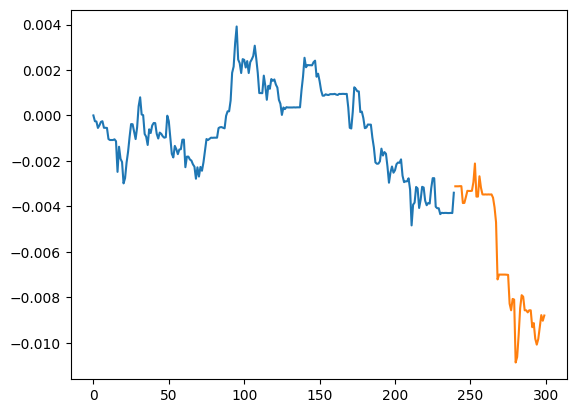

In [33]:
#plot random sample
rand_idx = np.random.randint(0, len(x))
plt.plot(np.arange(train_window_size), x[rand_idx,:,0].numpy())
plt.plot(np.arange(train_window_size, train_window_size+target_window_size), y[rand_idx,:].numpy())

In [35]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(train_window_size*42, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 60)
        
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        return x
    
model = Model()
print(model(x).shape)    

torch.Size([64, 60])


In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

losses = []
def train(model, data, lr=.0001, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            y = y.to(device)
            opt.zero_grad()
            x_hat = model(x)
            loss = ((y - x_hat)**2).mean()
            loss.backward()
            opt.step()
            losses.append(loss)
            print(f'epoch: {epoch}, loss: {loss}', end='\r')
    return model

model = model.to(device) # GPU
train(model, train_dl, lr=0.001, epochs=100)

C:\Users\avido\AppData\Local\Temp\ipykernel_1712\291220550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


C:\Users\avido\AppData\Local\Temp\ipykernel_1712\291220550.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].max() - 1


KeyboardInterrupt: 

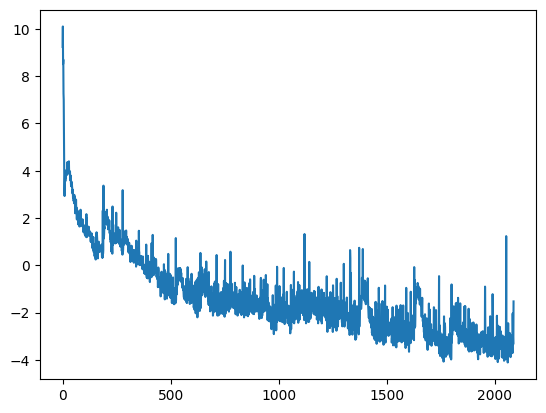

In [37]:
plt.plot([np.log(loss.cpu().detach().numpy()) for loss in losses])

In [17]:
#test on test set
model.eval()
test_losses = []
for x, y in test_dl:
    x = x.to(device) # GPU
    y = y.to(device)
    x_hat = model(x)
    loss = ((y - x_hat)**2).mean()
    test_losses.append(loss)
    print(f'loss: {loss}', end='\r')

print(f'average test loss: {np.mean(test_losses)}')

C:\Users\avido\AppData\Local\Temp\ipykernel_1712\614292479.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0]


KeyboardInterrupt: 

C:\Users\avido\AppData\Local\Temp\ipykernel_1712\291220550.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


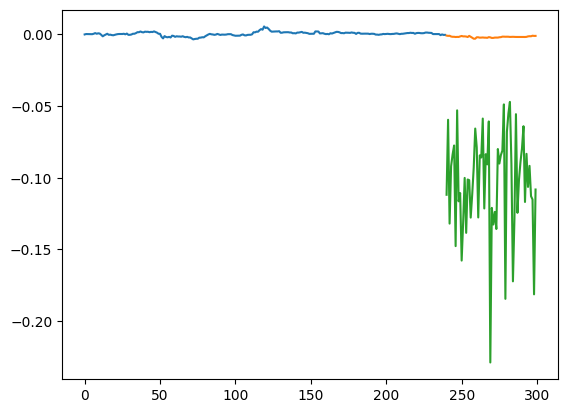

In [41]:
#plot an example
x, y = next(iter(test_dl))
rand_idx = np.random.randint(0, len(x))
plt.plot(np.arange(train_window_size), x[rand_idx,:,0].numpy())
plt.plot(np.arange(train_window_size, train_window_size+target_window_size), y[rand_idx,:].numpy())
plt.plot(np.arange(train_window_size, train_window_size+target_window_size), model(x[rand_idx,:,:].unsqueeze(0).to(device)).cpu().detach().numpy().squeeze())
